# Phase 1: Core Implementation

## 1.1 setup and imports

In [1]:
import torch                      # core tensor functionalities
import torch.nn as nn             # neural network modules, includes layers andloss
import torch.optim as optim       # built-in optimizers
import matplotlib.pyplot as plt   # visualizatio module

### 1.1.1 setup random seed - reproducibility

random seed is required because it ensures that the result is repeatable. It makes sure that the data shuffling is consistent. Most importantly, it ensures that the same initial weights are used every time.

In [2]:
torch.manual_seed(42)

### 1.1.2 Check GPU availability

Since this is a very small scale application of linear regression, I am not using GPU in this particular application. However, for larger scale or maybe for a different algorithm, we will need to use GPU. As a result, it is a standard practice to check the GPU availability

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"System is using device as {device}")

System is using device as cpu


## 1.2 Data Generation

Why are we doing this?<br>
We are creating a sythetic dataset that contains linear relationship between `x` - independent variables and `y` - dependent variable.

### 1.2.1 Create input features

In [4]:
X = torch.rand(100, 1) * 10     # gives us 100 values. 1 column, ragning from 0 to 10

### 1.2.2 Define ground thuth function

In [5]:
y = 2*X + 3

### 1.2.3 Add noise

why?<br>
because in real world, ther will always be noise. the relationship is never perfect.

There will always be
1. measuring error
2. natural randomness
3. man-made error

So, the best practice will be to use the noise here

In [6]:
y = y + torch.rand(100,1)

### 1.2.4 Visualization of X and y

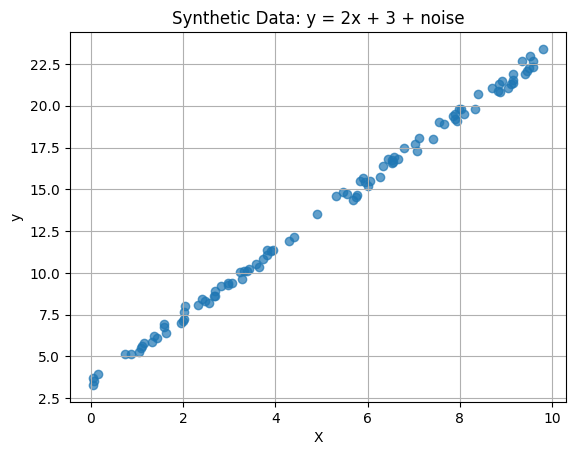

In [7]:
plt.scatter(X.numpy(), y.numpy(), alpha=0.7)
plt.title("Synthetic Data: y = 2x + 3 + noise")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.show()

## 1.3 Model definition: creating learnable parameters

Working mechanism:<br>
`nn.Linear(1,1)` - creates `2` learnable parameters, namely:`weight` and `bias`<br>
`weight` - slope: how steep the line is<br>
`bias` - interception: where the line crosses `y axis`

`forward` - just says use this equation when you get an input.

In [8]:
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    # create a layer that creates 1 input and 1 output
    # internally it will learn weight 'w' and bias 'b' for y = wx+b
    self.linear = nn.Linear(in_features=1, out_features=1)

  def forward(self, x):
    return self.linear(x)

### 1.3.1 check initial weight and bias

```text
model
├── linear (nn.Linear)
│   ├── weight (Parameter)
│   └── bias   (Parameter)
```

In [9]:
model = LinearRegression()

print(f"Initial Weight:{model.linear.weight.item():.4f}")
print(f"Initial Bias:{model.linear.bias.item():.4f}")

Initial Weight:-0.9083
Initial Bias:-0.3690


## 1.4 Loss functiona and Optimizer

What will we be doing?<br>
We are trying to set how the model learns.
1. Loss function: Measures how far the models predictions are from true values
2. Optimizer: adjusts the models weights and bias to minimize loss.


Loss function here is MSELoss() - because it is the most common for regression tasks

Optimizer is SGD here as it is one of the most easy and simple.

In [10]:
criterion = nn.MSELoss()                           # criterion(predictions, target) - loss

optimizer = optim.SGD(model.parameters(), lr=0.01) # model.parameters() -> access to weights and biases. after that the SGD optimizes the weights and biases.

## 1.5 Training Loop

What does training look like?<br>
```text
Guess -> Check -> Learn -> Improve -> Repeat
```
Each loop will be called an `epoch`.

In [11]:
# total training epochs
epochs = 1000

# list to store losses
losses = []             # this later is used for plotting

# starting the training loop
for epoch in range(epochs):
  # task 1: Guess
  y_pred = model(X)    # this is forward pass. Given the input X, what's the prediction?

  # task 2: Check
  loss = criterion(y_pred, y) # check how far off are the prediction compared to y

  # task 3: Learn
  # clear off old gradients first
  optimizer.zero_grad() # as pytorch accunulates gradients, this part is essential

  loss.backward() # calculate how each param contributed to the error
                  # pytorch automatically computes the gradients of the loss wrt each param
  # task 4: Improve
  optimizer.step() # adjust the weight and bias to reduce the loss next time

  # save the loss for plotting
  losses.append(loss.item())

  # auxiliary task: printing updates in every 100 epochs
  if (epoch+1)%100 == 0:
    print(f"Epoch {epoch+1}/{epochs}: Loss = {loss.item():.4f}")

Epoch 100/1000: Loss = 1.0848
Epoch 200/1000: Loss = 0.4623
Epoch 300/1000: Loss = 0.2234
Epoch 400/1000: Loss = 0.1317
Epoch 500/1000: Loss = 0.0965
Epoch 600/1000: Loss = 0.0830
Epoch 700/1000: Loss = 0.0778
Epoch 800/1000: Loss = 0.0758
Epoch 900/1000: Loss = 0.0751
Epoch 1000/1000: Loss = 0.0748


## 1.6 Print learned params

In [12]:
learned_weight = model.linear.weight.item()
learned_bias = model.linear.bias.item()

print(f"Learned Weight: {learned_weight:.4f}")
print(f"Learned Bias: {learned_bias:.4f}")

Learned Weight: 2.0149
Learned Bias: 3.3741


in here, our learned weight is 2.01 and learned bias is 2.37
if we remember, our original equation was `2X+3`. considering it equal to `wx+b`, the weight should have been 2 and bias to be 3. However, these obtained value through training is a bit off because of the noise we put into the model, which is very obvious and expected in a real-life scenario.

## 1.7 Visualize training loss curve

what will we plot? <br>
1. X-Axis: epoch 1 to 1000
2. Y-Axis: MSE loss value at each epoch

The curve here should drop sharply and then flatten out eventually

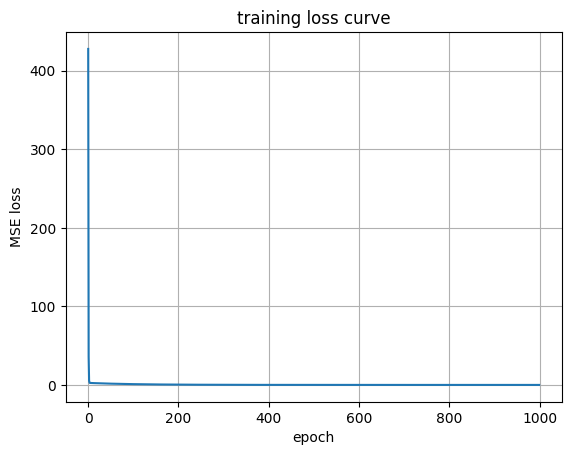

In [13]:
plt.plot(losses)
plt.title("training loss curve")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.grid(True)
plt.show()

## 1.8 Plot the learned regression line

it essentially draws the best-fit line through the data

it will be a scatterplot if the X and y along with my model's prediction.

Even though we have not saved the models params explicitly. we have it saved on the model's object. when we called `optimizer.step()`, pytorch updated the weights and bias on the model's object. So, we will see that when we code the next part, we wont need any gradients because that is an unnecessary calculation now.


if the question arises that when we need to save the model then?
`torch.save(model.state_dict(), "model.pth")`

and later

`torch.load_state_dict(torch.load("model.pth"))`

1. if we are shutting dowsn the notebook
2. we want to share it or load later

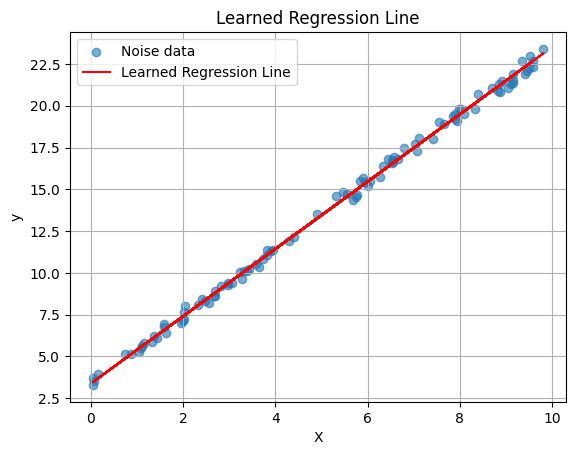

In [14]:
# no gradient tracking is required for plotting
with torch.no_grad():

  # prediction - GUESS
  predicted = model(X)

  # now that we have X and y(predicted), we can form the scatter plot
  plt.scatter(
      X.numpy(), # matplotlib only understands numpy array. not pytorch tensors
      y.numpy(),
      label='Noise data',
      alpha=0. # opacity param. it is required for overplotting
    )

  # line plot of te predictions
  plt.plot(
      X.numpy(),
      predicted.numpy(),
      color='red',
      label='Learned Regression Line'
    )

  plt.title("Learned Regression Line")
  plt.xlabel("X")
  plt.ylabel("y")
  plt.legend()
  plt.grid(True)
  plt.show()


  """
  if the tensors were created in GPU, we must move it back to CPU first
  -> X.cpu().numpy()
  -> y.cpu().numpy()
  -> predicted.cpu().numpy()
  """

## 1.9 Predict on New(Unseen) input values

we just want to make sure that if the model
1. make reasonable predictions for the new values it has not seen befofe?
2. does it still follow the same linear patter it learned?

In [20]:
# define new input values
X_test = torch.tensor([[4.0], [7.0]])

# use the trained model to predict outputs
with torch.no_grad():
  # prediction
  predictions = model(X_test)

# print predictions
for i, x_value in enumerate(X_test):
  print(f"Input: {x_value.item()} -> predicted output: {predictions[i].item():.4f}")

# if it follows the original equation
for i, x_value in enumerate(X_test):
  print(f"Original Equation value output: {2*x_value.item()+3:.4f}")

# if it follows model's learned param
for i, x_value in enumerate(X_test):
  print(f"Learned Equation value output: {learned_weight*x_value.item()+learned_bias:.4f}")

Input: 4.0 -> predicted output: 11.4337
Input: 7.0 -> predicted output: 17.4784
Original Equation value output: 11.0000
Original Equation value output: 17.0000
Learned Equation value output: 11.4337
Learned Equation value output: 17.4784
